In [27]:
#-------------------------Imports---------------------------
import numpy as np
#import healpy as hp
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits import mplot3d
#import sympy as sy
#import numba
from numpy.random import random

from scipy.stats import kstest
from scipy.stats import uniform
from scipy import interpolate

import h5py
import os
from astropy.cosmology import Planck15
from astropy.cosmology import FlatLambdaCDM

###########################
# CONSTANTS
###########################
H0GLOB= 69#67.9 #69
Om0GLOB=0.3
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s

xmax=100
ymax=100
zmax=100
half_box_size=2

Npoints=1000
Sigma=10

cosmoglob = Planck15
cosmofast = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
H0=cosmoglob.H(0).value

In [2]:
#--------------------------definitions-------------------------
def NumOfDS(x,y,z):
    #this will evaluate the dN/dz
    r=np.sqrt(x**2+y**2+z**2)
    #numberofDS=1000/r
    numberofDS=1000
    num=int(numberofDS)
    #print(num)
    if num>0:
        return num
    else:
        return 1
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples
#--------------Placer-----------------------------
def DS_Maker(radii,perc,numHost,xhost,yhost,zhost):
    #the DSs are generated in a sphere, centered on the host. and the distance must follow
#the correlation distribution. 
#To generate points on a unit sphere see https://mathworld.wolfram.com/SpherePointPicking.html
# A python implementation https://stackoverflow.com/questions/5408276/sampling-uniformly-distributed-random-points-inside-a-spherical-volume
    #remember: you have to return also the indices of the hosts that have DSs
    x_Dark=[]
    y_Dark=[]
    z_Dark=[]
    arr_n=[]
    NDS=int(perc*numHost)
    indices=np.zeros(NDS)
    
    for k in range(NDS):
        i=np.random.randint(0, numHost-1)
        indices[k]=i
        dist_x=xhost[i]
        dist_y=yhost[i]
        dist_z=zhost[i]
        n=NumOfDS(dist_x,dist_y,dist_z)
        arr_n=np.append(arr_n,n)
        for d in range(n):
            phi =np.random.uniform(0,2*np.pi)
            costheta =np.random.uniform(-1,1)
            theta = np.arccos(costheta)
            r=np.random.choice(radii)
            #u =np.random.uniform(0,1)
            #r =R *np.cbrt(u) #If you have to fill a fixer sphere of radious R
            x_DS = r * np.sin( theta) * np.cos( phi )
            y_DS = r * np.sin( theta) * np.sin( phi )
            z_DS = r * np.cos( theta )
        
            x_Dark=np.append(x_Dark,dist_x+x_DS)
            y_Dark=np.append(y_Dark,dist_y+y_DS)
            z_Dark=np.append(z_Dark,dist_z+z_DS)
    #--------only unique indices of host-DS
    filtered=np.unique(indices)
    return x_Dark, y_Dark, z_Dark, filtered, arr_n


In [3]:
#----------------------Create the box & fill it with hosts-------------------
x=np.random.normal(loc=0,scale=Sigma,size=Npoints)
y=np.random.normal(loc=0,scale=Sigma,size=Npoints)
z=np.random.normal(loc=0,scale=Sigma,size=Npoints)

Text(0.5, 0, 'z')

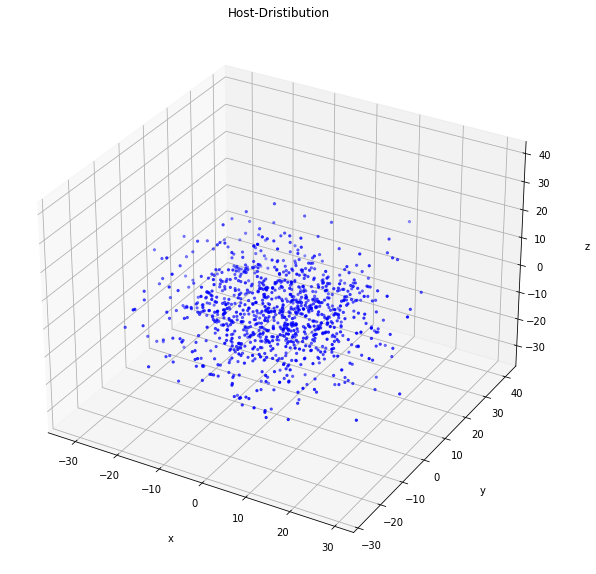

In [4]:
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(x, y, z, c = 'b', s = 5)
ax.set_title('Host-Dristibution')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
#plt.savefig('HostDist.pdf')

In [ ]:
'''#-------This will be movend into a function
x_Dark=[]
y_Dark=[]
z_Dark=[]
arr_n=[]
perc=0.4
NDS=int(perc*Npoints)
indices=np.zeros(NDS)
for k in range(NDS):
    i=np.random.randint(0, Npoints-1)
    indices[k]=i
    dist_x=x[i]
    dist_y=y[i]
    dist_z=z[i]
    n=NumOfDS(dist_x,dist_y,dist_z)
    arr_n=np.append(arr_n,n)
    x_DS=np.random.uniform(-half_box_size,half_box_size,n)
    y_DS=np.random.uniform(-half_box_size,half_box_size,n)
    z_DS=np.random.uniform(-half_box_size,half_box_size,n)
    
    #x_DS=np.random.uniform(0,1,n)
    #y_DS=np.random.uniform(0,1,n)
    #z_DS=np.random.uniform(0,1,n)
    
    x_Dark=np.append(x_Dark,dist_x+x_DS)
    y_Dark=np.append(y_Dark,dist_y+y_DS)
    z_Dark=np.append(z_Dark,dist_z+z_DS)
#--------only unique indices of host-DS
filtered=np.unique(indices)'''

In [5]:
#----------------MC-rejection-with-CDF----------------------
h=H0/100
r0=5*h
gamma=1.8
rmin=0.1*h
rmax=10*h
#target function
target_dist= lambda r: (r/r0)**(-gamma)
#x = sy.Symbol('x')
#print(sy.integrate(target_dist(x), (x, rmin, rmax)))
values=return_samples(target_dist,rmin,rmax,1000000)

In [6]:
x_Dark, y_Dark, z_Dark, filtered, arr_n=DS_Maker(values,0.10,Npoints,x,y,z)
print(len(x_Dark))

100000


Text(0.5, 0, 'z')

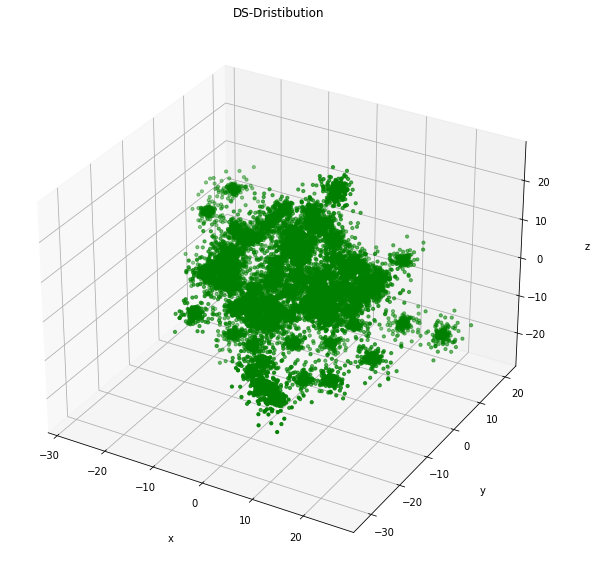

In [7]:
fig2 = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()

ax.scatter(x_Dark, y_Dark, z_Dark, c = 'g', s = 10)
ax.set_title('DS-Dristibution')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)
#plt.savefig('DSDist.pdf')

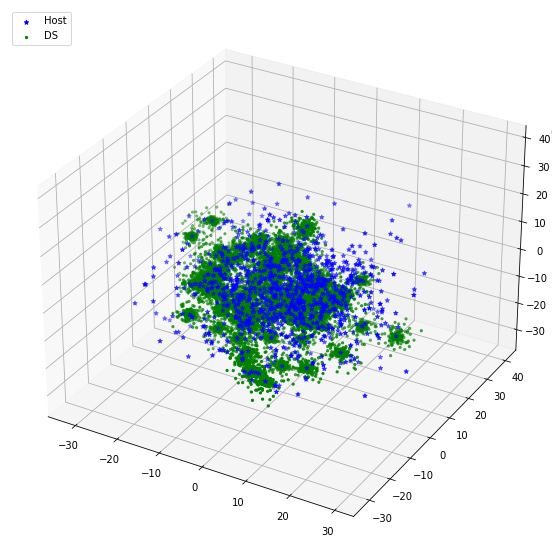

In [8]:
figtot = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.grid()
ax1 = figtot.add_subplot(111,projection='3d')

ax1.scatter(x, y, z, c = 'b', marker="*", label='Host')
ax1.scatter(x_Dark, y_Dark, z_Dark, s=5, c = 'g', marker="o", label='DS')
plt.legend(loc='upper left');
#plt.savefig('DS_and_Host.pdf')

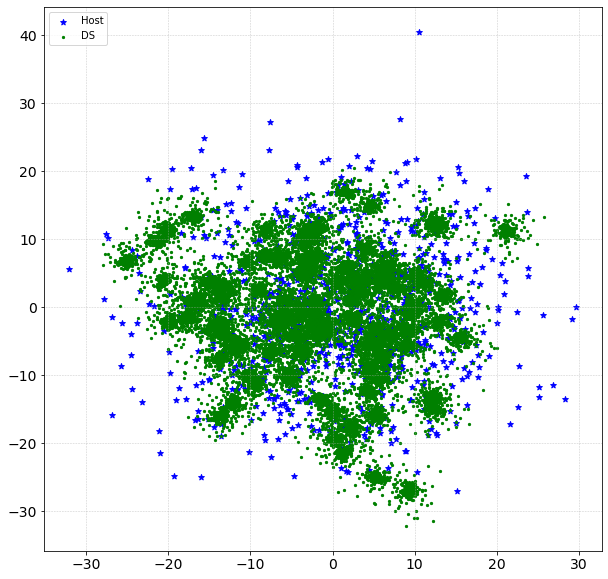

In [12]:
figtot2dxy = plt.figure(figsize = (10,10))
ax = plt.axes()
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(linestyle='dotted', linewidth='0.6')
ax.scatter(x, y, c = 'b', marker="*", label='Host')
ax.scatter(x_Dark, y_Dark, s=5, c = 'g', marker="o", label='DS')
plt.legend(loc='upper left');
#plt.savefig('DS_and_Host_xy.pdf')

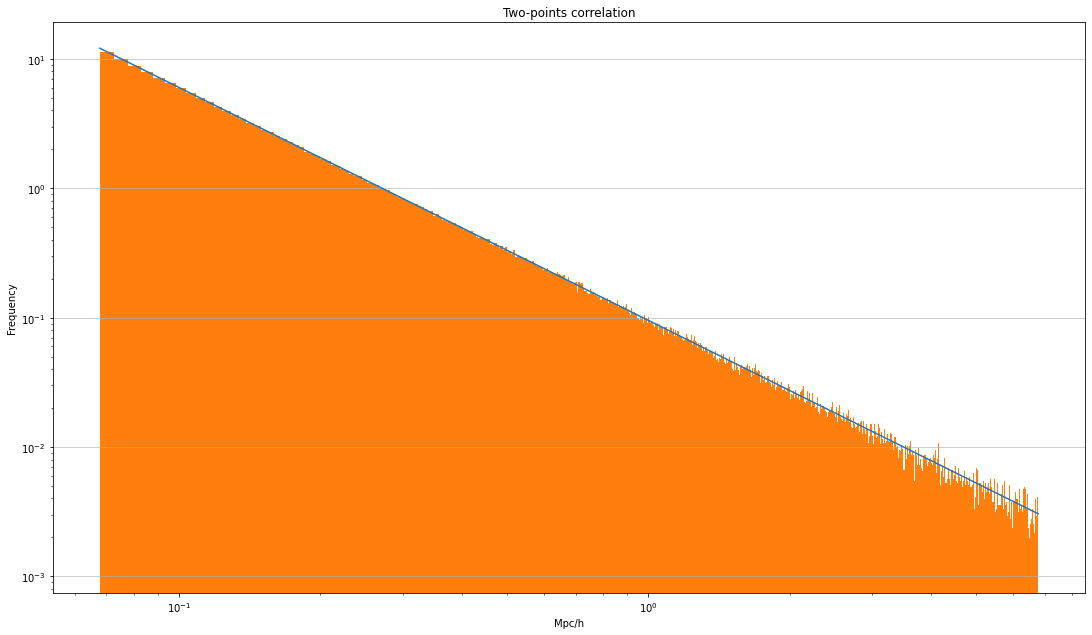

In [13]:
## plot of the rejection results

x = np.linspace(rmin,rmax,1000000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.set_ylabel('probability density')
ax.plot(x,target_dist(x)/np.sum(target_dist(x)*(x[1]-x[0])) )
#ax.plot(x,target_dist(x)/norm ) #slow
ax.hist(values,bins='auto',density=True,range=(x.min(),x.max()))
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.title('Two-points correlation')
plt.show() 

In [ ]:
'''test=np.random.choice(values,1000000)
plt.figure(figsize=(10,10)) 
n, bins, patches = plt.hist(x=test, bins='auto',density=True, color='#009171',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc/h')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.title('Two-points correlation')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 2)
plt.ylim(ymax=np.ceil(maxfreq))'''

In [15]:
#--------------test-----------------
all_px=[]
all_py=[]
all_pz=[]
#this works is there is at least 1 DS for an Host
for h in range(len(filtered)):
    if h==0:
        pos=0
    n=int(arr_n[h])
    if n==1:
        xdata=x_Dark[pos]-x[int(filtered[h])]
        ydata=y_Dark[pos]-y[int(filtered[h])]
        zdata=z_Dark[pos]-z[int(filtered[h])]
    else:
        xdata=x_Dark[pos:pos+n]-x[int(filtered[h])]
        ydata=y_Dark[pos:pos+n]-y[int(filtered[h])] 
        zdata=z_Dark[pos:pos+n]-z[int(filtered[h])] 
        
    pos=(pos+n)

    statx,pvaluex=kstest(xdata,'uniform',args=(-half_box_size,half_box_size))
    staty,pvaluey=kstest(ydata,'uniform',args=(-half_box_size,half_box_size))
    statz,pvaluez=kstest(zdata,'uniform',args=(-half_box_size,half_box_size))
    all_px=np.append(all_px,statx)
    all_py=np.append(all_py,staty)
    all_pz=np.append(all_pz,statz)

print(np.mean(all_px))
print(np.mean(all_py))
print(np.mean(all_pz))

0.9625957144530591
0.9584123055570375
0.9709856793892886


In [ ]:
def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec
from mpl_toolkits.mplot3d import axes3d

phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
x = np.outer(np.sin(theta), np.cos(phi))# outer product i.e. line*row
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

xi, yi, zi = sample_spherical(1000)

fig, ax = plt.subplots(1, 1,subplot_kw={'projection':'3d'})
fig.set_size_inches(10.5, 10.5)
ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(xi, yi, zi, s=100, c='r', zorder=10)

True
True


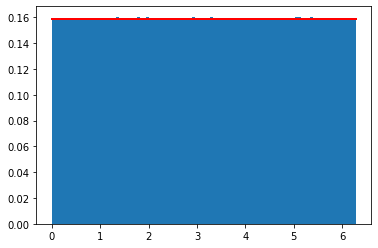

In [16]:

phi =np.random.uniform(0,2*np.pi,10000000)
print(np.all(phi>=0))
print(np.all(phi<=2*np.pi))
count, bins, ignored = plt.hist(phi, 100, density=True)
line=np.ones_like(bins)
line=line/(2*np.pi)
plt.plot(bins, line, linewidth=2, color='r')
plt.show()

In [50]:
phi =np.random.uniform(0,2*np.pi,100)
costheta =np.random.uniform(-1,1,100)
theta = np.arccos(costheta)
r=1#np.random.choice(values,100)
#u =np.random.uniform(0,1)
#r =R *np.cbrt(u) #If you have to fill a fixer sphere of radious R
x_sph = r * np.sin( theta) * np.cos( phi )
y_sph = r * np.sin( theta) * np.sin( phi )
z_sph = r * np.cos( theta )


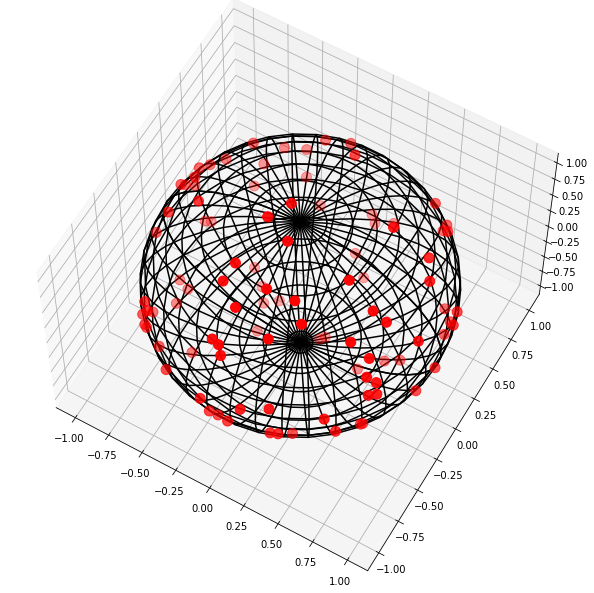

In [53]:
wire_phi = np.linspace(0, np.pi, 20)
wire_theta = np.linspace(0, 2 * np.pi, 40)
x = 1*np.outer(np.sin(wire_theta), np.cos(wire_phi))# outer product i.e. line*row
y = 1*np.outer(np.sin(wire_theta), np.sin(wire_phi))
z = 1*np.outer(np.cos(wire_theta), np.ones_like(wire_phi))
fig, ax = plt.subplots(1, 1,subplot_kw={'projection':'3d'})
fig.set_size_inches(10.5, 10.5)
ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(x_sph, y_sph , z_sph, s=100, c='r', zorder=10)
ax.view_init(60, -60)